In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import alexnet

# Path to the dataset
dataset_path = 'folder'

# Transformations for the input data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load dataset using ImageFolder
full_dataset = ImageFolder(root=dataset_path, transform=transform)

# Splitting dataset into training and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [3]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import alexnet
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
# Load pre-trained AlexNet
model = alexnet(pretrained=True)

# Modify the classifier for 5 classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to perform training and validation
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size

        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
        val_precision = precision_score(all_labels, all_preds, average='macro')
        val_recall = recall_score(all_labels, all_preds, average='macro')
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}')

        # Save the model if validation accuracy has improved
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    return model

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/sabrierendagdelen/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:09<00:00, 25.4MB/s] 
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25, Loss: 1.8016, Acc: 0.1787, Val Acc: 0.1900, Precision: 0.0380, Recall: 0.2000, F1: 0.0639
Epoch 2/25, Loss: 1.6213, Acc: 0.1875, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/25, Loss: 1.6188, Acc: 0.2000, Val Acc: 0.1900, Precision: 0.0380, Recall: 0.2000, F1: 0.0639


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/25, Loss: 1.6156, Acc: 0.1938, Val Acc: 0.1800, Precision: 0.0360, Recall: 0.2000, F1: 0.0610


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/25, Loss: 1.6135, Acc: 0.1888, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/25, Loss: 1.6131, Acc: 0.2125, Val Acc: 0.1800, Precision: 0.0360, Recall: 0.2000, F1: 0.0610


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/25, Loss: 1.6134, Acc: 0.1837, Val Acc: 0.1900, Precision: 0.0380, Recall: 0.2000, F1: 0.0639


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/25, Loss: 1.6106, Acc: 0.1950, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/25, Loss: 1.6110, Acc: 0.2075, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/25, Loss: 1.6108, Acc: 0.1950, Val Acc: 0.1800, Precision: 0.0360, Recall: 0.2000, F1: 0.0610


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/25, Loss: 1.6101, Acc: 0.1963, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/25, Loss: 1.6116, Acc: 0.1888, Val Acc: 0.1800, Precision: 0.0360, Recall: 0.2000, F1: 0.0610


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/25, Loss: 1.6101, Acc: 0.1938, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/25, Loss: 1.6107, Acc: 0.1762, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/25, Loss: 1.6107, Acc: 0.2050, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/25, Loss: 1.6105, Acc: 0.2025, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/25, Loss: 1.6105, Acc: 0.2000, Val Acc: 0.1800, Precision: 0.0360, Recall: 0.2000, F1: 0.0610


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/25, Loss: 1.6104, Acc: 0.1888, Val Acc: 0.1900, Precision: 0.0380, Recall: 0.2000, F1: 0.0639


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/25, Loss: 1.6100, Acc: 0.1975, Val Acc: 0.1800, Precision: 0.0360, Recall: 0.2000, F1: 0.0610


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/25, Loss: 1.6102, Acc: 0.2100, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21/25, Loss: 1.6095, Acc: 0.2050, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/25, Loss: 1.6095, Acc: 0.2025, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/25, Loss: 1.6103, Acc: 0.1862, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24/25, Loss: 1.6096, Acc: 0.2062, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/25, Loss: 1.6095, Acc: 0.2050, Val Acc: 0.1750, Precision: 0.0350, Recall: 0.2000, F1: 0.0596


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


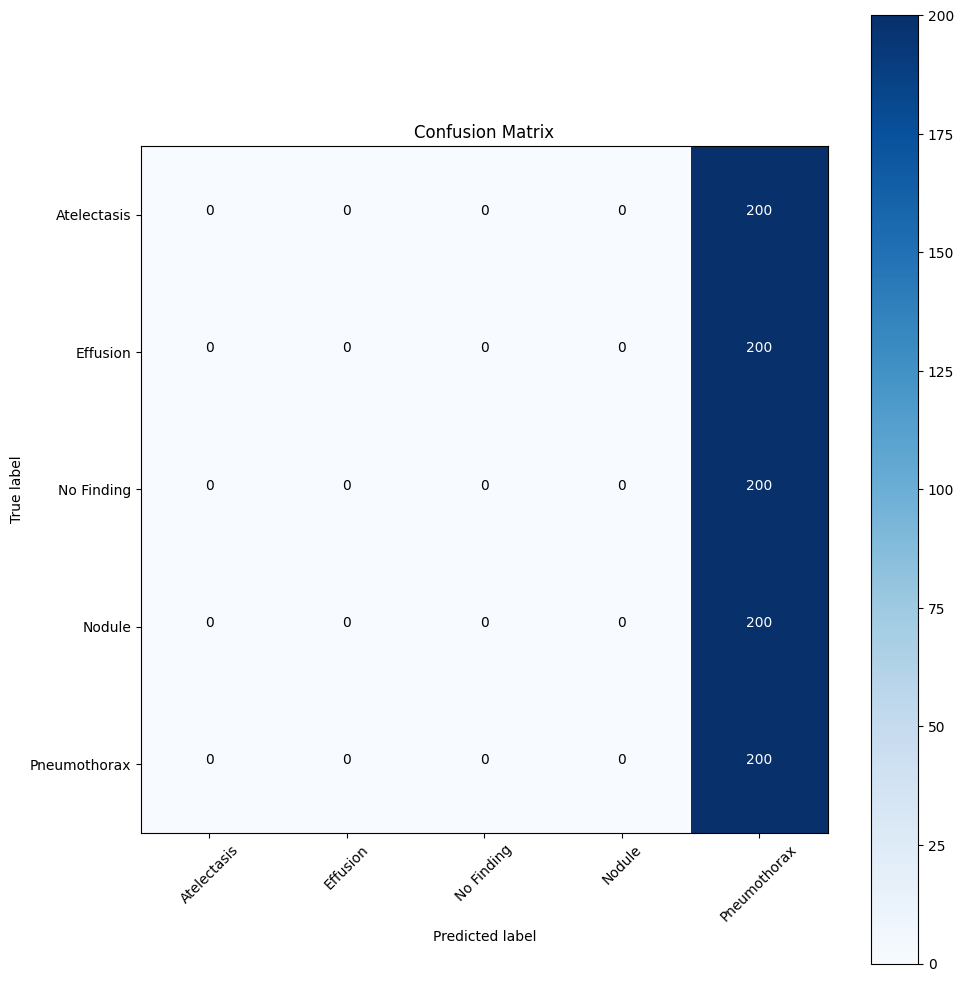

In [4]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from torchvision import datasets, transforms
from torchvision.models import alexnet
from torch.utils.data import DataLoader
import numpy as np
import itertools

# Load the model
model = alexnet(pretrained=False)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 5)  # Adjusting for 5 classes
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set model to evaluation mode

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Data loader for validation set (assuming setup is same as before)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root='folder', transform=transform)
val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Function to evaluate the model and plot metrics
def evaluate_and_plot(model, loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    np.set_printoptions(precision=2)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(dataset.classes))
    plt.xticks(tick_marks, dataset.classes, rotation=45)
    plt.yticks(tick_marks, dataset.classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve plotting can be added here if needed

# Call the evaluation and plotting function
evaluate_and_plot(model, val_loader)
